# **Übung 1, Aufgabe 1 (Grundmodell)**

**Einordnung in Übung 1:**

- **Aufgabe 1: Grundmodell der Produktionsprogrammplanung (PPP)**
- Aufgabe 2: Grundmodell mit Zielkonflikt
- Aufgabe 3: Erweiterung um mehrere Perioden und Lagerbestände

## **Aufgabenstellung**

- Ein gewinnmaximierendes Unternehmen produziert in einem zweistufigen Fertigungsprozess drei Produktarten (j=1,2,3).
- Dazu stehen die folgenden Daten zur Verfügung:

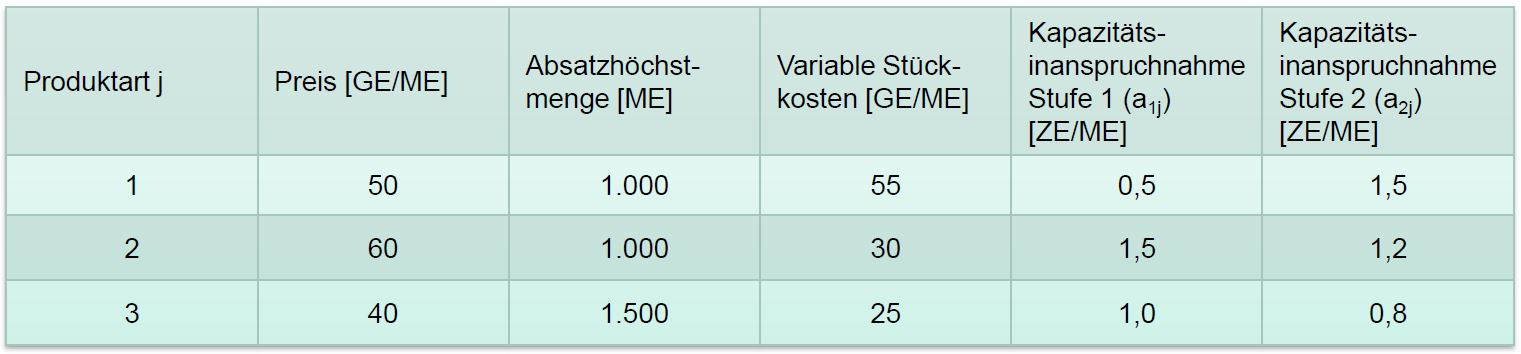

In [1]:
from IPython.display import Image
Image(filename='Images/A1_data1.JPG', width=700)

- Es fallen fixe Kosten in Höhe von Kfix = 20.000 GE innerhalb der Periode an
- Die Kapazitäten sind auf 1.500 ZE auf Fertigungsstufe 1 bzw. 2.500 ZE auf Fertigungsstufe 2 beschränkt

## **Vorbereitung**

### **Python-Module**

In [2]:
import numpy as np
import pandas as pd
from pulp import *

### **Daten aus der Aufgabenstellung**

**Produktionskoeffizienten (Kapazitätsinanspruchnahme) der drei Produkte in den zwei Stufen:**

In [3]:
a = pd.DataFrame()

a.loc['Produkt1','Stufe1'] = 0.5
a.loc['Produkt2','Stufe1'] = 1.5
a.loc['Produkt3','Stufe1'] = 1.0
a.loc['Produkt1','Stufe2'] = 1.5
a.loc['Produkt2','Stufe2'] = 1.2
a.loc['Produkt3','Stufe2'] = 0.8

Produkte = a.index.tolist()
Stufen = a.columns.tolist()

print(a)

          Stufe1  Stufe2
Produkt1     0.5     1.5
Produkt2     1.5     1.2
Produkt3     1.0     0.8


$$ $$
**Maximale Kapazitäten der zwei Stufen:**

In [4]:
# Kapazitaeten
r = pd.DataFrame()
r.loc['Stufe1','r'] = 1500
r.loc['Stufe2','r'] = 2500
print(r)

             r
Stufe1  1500.0
Stufe2  2500.0


$$ $$
**Preise, Stückkosten und Absatzhöchstmengen der drei Produkte:**

In [5]:
# Weitere Inputdaten
data = pd.DataFrame()

data.loc['Produkt1','Preis'] = 50
data.loc['Produkt1','Absatzhoechstmenge'] = 1000
data.loc['Produkt1','VariableStueckkosten'] = 55

data.loc['Produkt2','Preis'] = 60
data.loc['Produkt2','Absatzhoechstmenge'] = 1000
data.loc['Produkt2','VariableStueckkosten'] = 30

data.loc['Produkt3','Preis'] = 40
data.loc['Produkt3','Absatzhoechstmenge'] = 1500
data.loc['Produkt3','VariableStueckkosten'] = 25

data['DB'] = data['Preis'] - data['VariableStueckkosten'] #Deckungsbeitrag
print(data)

          Preis  Absatzhoechstmenge  VariableStueckkosten    DB
Produkt1   50.0              1000.0                  55.0  -5.0
Produkt2   60.0              1000.0                  30.0  30.0
Produkt3   40.0              1500.0                  25.0  15.0


$$ $$
## **Optimierungsproblem**

#### **Problemformulierung**


$$\max \sum_{i}x_i \cdot DB_i$$

$$ Restriktionen: $$

$$ \sum_{i}a_{ij} \cdot x_i \leq r_{j} \quad \forall j \in J $$

$$ x_i \leq A_{i} \quad \forall i \in I $$

$$ x_i \geq 0 \quad \forall i \in I $$

$$ \textrm{mit Produkten $I$ und Stufen $J$} $$.


#### **Formulierung mit PuLP:**

In [6]:
prob = LpProblem('Problem_BasisModell', LpMaximize)

x = LpVariable.dicts('x', Produkte, lowBound=0)

prob += lpSum([x[i]*data.loc[i,'DB'] for i in Produkte])

for j in Stufen:
    prob += lpSum([x[i]* a.loc[i,j] for i in Produkte]) <= r.loc[j,'r']
    
for i in Produkte:
    prob += x[i] <= data.loc[i,'Absatzhoechstmenge']
    
print(prob)

Problem_BasisModell:
MAXIMIZE
-5.0*x_Produkt1 + 30.0*x_Produkt2 + 15.0*x_Produkt3 + 0.0
SUBJECT TO
_C1: 0.5 x_Produkt1 + 1.5 x_Produkt2 + x_Produkt3 <= 1500

_C2: 1.5 x_Produkt1 + 1.2 x_Produkt2 + 0.8 x_Produkt3 <= 2500

_C3: x_Produkt1 <= 1000

_C4: x_Produkt2 <= 1000

_C5: x_Produkt3 <= 1500

VARIABLES
x_Produkt1 Continuous
x_Produkt2 Continuous
x_Produkt3 Continuous



$$ $$
#### **Ergebnis**

In [7]:
prob.writeLP("Problem_BasisModell.lp")
prob.solve()

print("Status:", LpStatus[prob.status])
print("Erzielter Deckungsbeitrag = {:,.0f} GE".format(value(prob.objective)))
print()

for i in Produkte:
    print('Optimale Produktionsmenge {}: {:,.2f} ME'.format(i, x[i].varValue))

Status: Optimal
Erzielter Deckungsbeitrag = 30,000 GE

Optimale Produktionsmenge Produkt1: 0.00 ME
Optimale Produktionsmenge Produkt2: 1,000.00 ME
Optimale Produktionsmenge Produkt3: 0.00 ME


$$ $$
#### **Plotten des Problems (nur Produkt 2 und 3) und des optimalen Produktionsprogramms:**

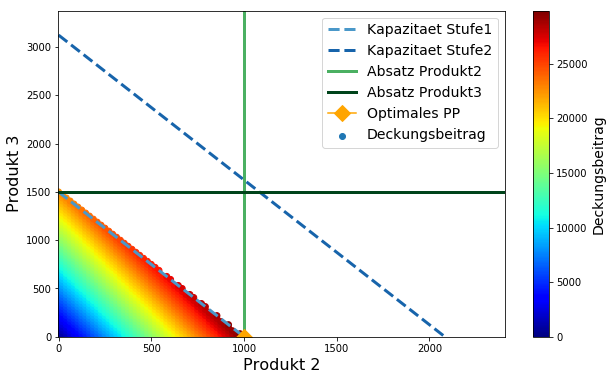

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

max_x2 = max([r.loc[j,'r']/a.loc['Produkt2',j] for j in Stufen]+[data.loc['Produkt2','Absatzhoechstmenge']])
max_x3 = max([r.loc[j,'r']/a.loc['Produkt3',j] for j in Stufen]+[data.loc['Produkt3','Absatzhoechstmenge']])

fig, ax = plt.subplots(figsize=(10, 6))
s = np.linspace(0, 1.1*max_x2)

# Kapazitätsrestriktionen
colors1 = plt.cm.Blues(np.linspace(0.6,1.0,3))
n = 0
for j in Stufen:    
    plt.plot(s,(r.loc[j,'r']-s*a.loc['Produkt2',j])/a.loc['Produkt3',j], lw=3,
             c=colors1[n], linestyle='dashed', label='Kapazitaet '+j)
    n += 1
    
# Absatzrestriktionen
colors2 = plt.cm.Greens(np.linspace(0.6,1.0,2))
plt.axvline(x=data.loc['Produkt2','Absatzhoechstmenge'], lw=3,
            c=colors2[0],linestyle='solid', label='Absatz Produkt2')
plt.axhline(y=data.loc['Produkt3','Absatzhoechstmenge'], lw=3,
            c=colors2[1], linestyle='solid', label='Absatz Produkt3')

# Zielfunktion plotten
pairs = [(xx, yy) for xx in np.arange(0, 1.1*max_x2, max_x2/100)
                for yy in np.arange(0, 1.1*max_x3, max_x3/100)
                if (xx * a.loc['Produkt2','Stufe1'] + yy * a.loc['Produkt3','Stufe1']) <= r.loc['Stufe1','r']
                and (xx * a.loc['Produkt2','Stufe2'] + yy * a.loc['Produkt3','Stufe2']) <= r.loc['Stufe2','r']        
                and xx <= data.loc['Produkt2','Absatzhoechstmenge']
                and yy <= data.loc['Produkt3','Absatzhoechstmenge']]

xxx, yyy = np.hsplit(np.array(pairs), 2)
z = xxx * data.loc['Produkt2','DB']  + yyy * data.loc['Produkt3','DB']  # the objective function
plt.scatter(xxx, yyy, c=z, cmap='jet', label='Deckungsbeitrag', zorder=2)

# Optimales Produktionsprogramm
plt.plot([x['Produkt2'].varValue], [x['Produkt3'].varValue], marker='D', markersize=12,
         label='Optimales PP', color="orange")


# Diagramm erstellen
cb = plt.colorbar()
cb.set_label('Deckungsbeitrag', fontsize=14)
plt.xlabel('Produkt 2', fontsize=16)
plt.ylabel('Produkt 3', fontsize=16)
plt.xlim(left=-0.5)
plt.ylim(bottom=-0.5)
plt.legend(fontsize=14)
plt.show()